In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure X: Mobility into San Diego is dominated by nearby locations
Estimated weekly travel counts into San Diego show both the magnitude and temporal dynamics of travel into San Diego during the pandemic.

We first load mobility data from SafeGraph that has been prepared as in Zeller et al. 2020. We noticed that travel from internation locations increased uniformly from 2019 to 2020, but that increase wasn't consistent with independent mobility data sources. To correct this artifact, we normalized mobility data for each location from January 1st, 2020 onward by multiplying it by the ratio of the mean mobility between January 1st and March 1st in 2019 compared to 2020.

For ease of viewing, we sort the mobility matrix by each locations total amount of travellers into San Diego from 2020 onwards.

In [2]:
def correct_mobility( entry ):
    start = "2019-03-01"
    end = "2019-12-29"

    return_df = entry.copy()
    mean2019 = entry.loc[entry["date_range_start"] < start,"true_visitor_count"].mean()
    mean2020 = entry.loc[entry["date_range_start"].between( end, "2020-03-01"),"true_visitor_count"].mean()
    ratio = mean2019 / mean2020


    return_df["corrected_visitor_count"] = return_df["true_visitor_count"]
    if (mean2019 == 0) or (mean2020 == 0):
        return return_df

    return_df.loc[entry["date_range_start"] > end, "corrected_visitor_count"] = return_df["true_visitor_count"] * ratio
    return return_df

st = pd.read_csv( "../data/mobility_states.csv", parse_dates=["date_range_start"] )
st = st.drop( columns=["California"] )
st = st.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

cr = pd.read_csv("../data/mobility_countries.csv", parse_dates=["date_range_start"] )
cr = cr.drop( columns=["Georgia", "United States"] )
cr = cr.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

ca = pd.read_csv( "../data/mobility_ca-counties.csv", parse_dates=["date_range_start"] )
ca = ca.melt( id_vars=["date_range_start"], var_name="location", value_name="true_visitor_count" )

mob = pd.concat( [st, cr, ca] )
mob = mob.groupby( "location" ).apply( correct_mobility ).reset_index( drop=True )

# Run diagnostics on unaltered DataFrame
diagnostic_df = mob.copy()

mob_mat = mob.pivot( index="date_range_start", columns="location", values="corrected_visitor_count" )
mobility_order = mob_mat.loc[mob_mat.index > "2019-12-29"].sum().sort_values( ascending=False ).index
mob_mat = mob_mat.reindex( columns=mobility_order )
mob_mat.head()

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3161503558.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3161503558.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3161503558.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3161503558.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3161503558.py:8: RuntimeWarning: invalid value encountered in double_scalars
  ratio = mean2019 / mean2020
/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3161503558.py:8: RuntimeWarning: invalid value encountered in double_scala

location,Riverside County,Los Angeles County,Orange County,Arizona,Mexico,San Bernardino County,Texas,Nevada,Florida,Washington,...,South Sudan,Faroe Islands,Sierra Leone,Seychelles,Guinea,Jersey,Kyrgyzstan,"Micronesia, Federated States of",Mozambique,Zimbabwe
date_range_start,,,,,,,,,,,,,,,,,,,,,
2019-01-07,77863.266,49388.780,37412.844,16813.560608,44991.330,16307.298,20813.039544,9756.815551,9216.801453,9081.798273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-01-14,76360.086,50436.355,37120.996,20107.565341,41104.812,17325.422,21653.199559,9803.332422,10298.507941,10455.933639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-01-21,83053.740,58511.790,43033.832,19319.667557,41168.895,18466.880,20264.123175,9080.660832,10416.787259,10139.006277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-01-28,75782.560,44737.848,31237.934,14926.174372,45540.637,15490.577,16550.740375,6602.499615,9866.885271,5781.318538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2019-02-04,77509.266,53122.640,36445.625,17898.672831,46502.164,17854.766,16945.627435,7756.091690,10452.515394,8200.330026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.802998


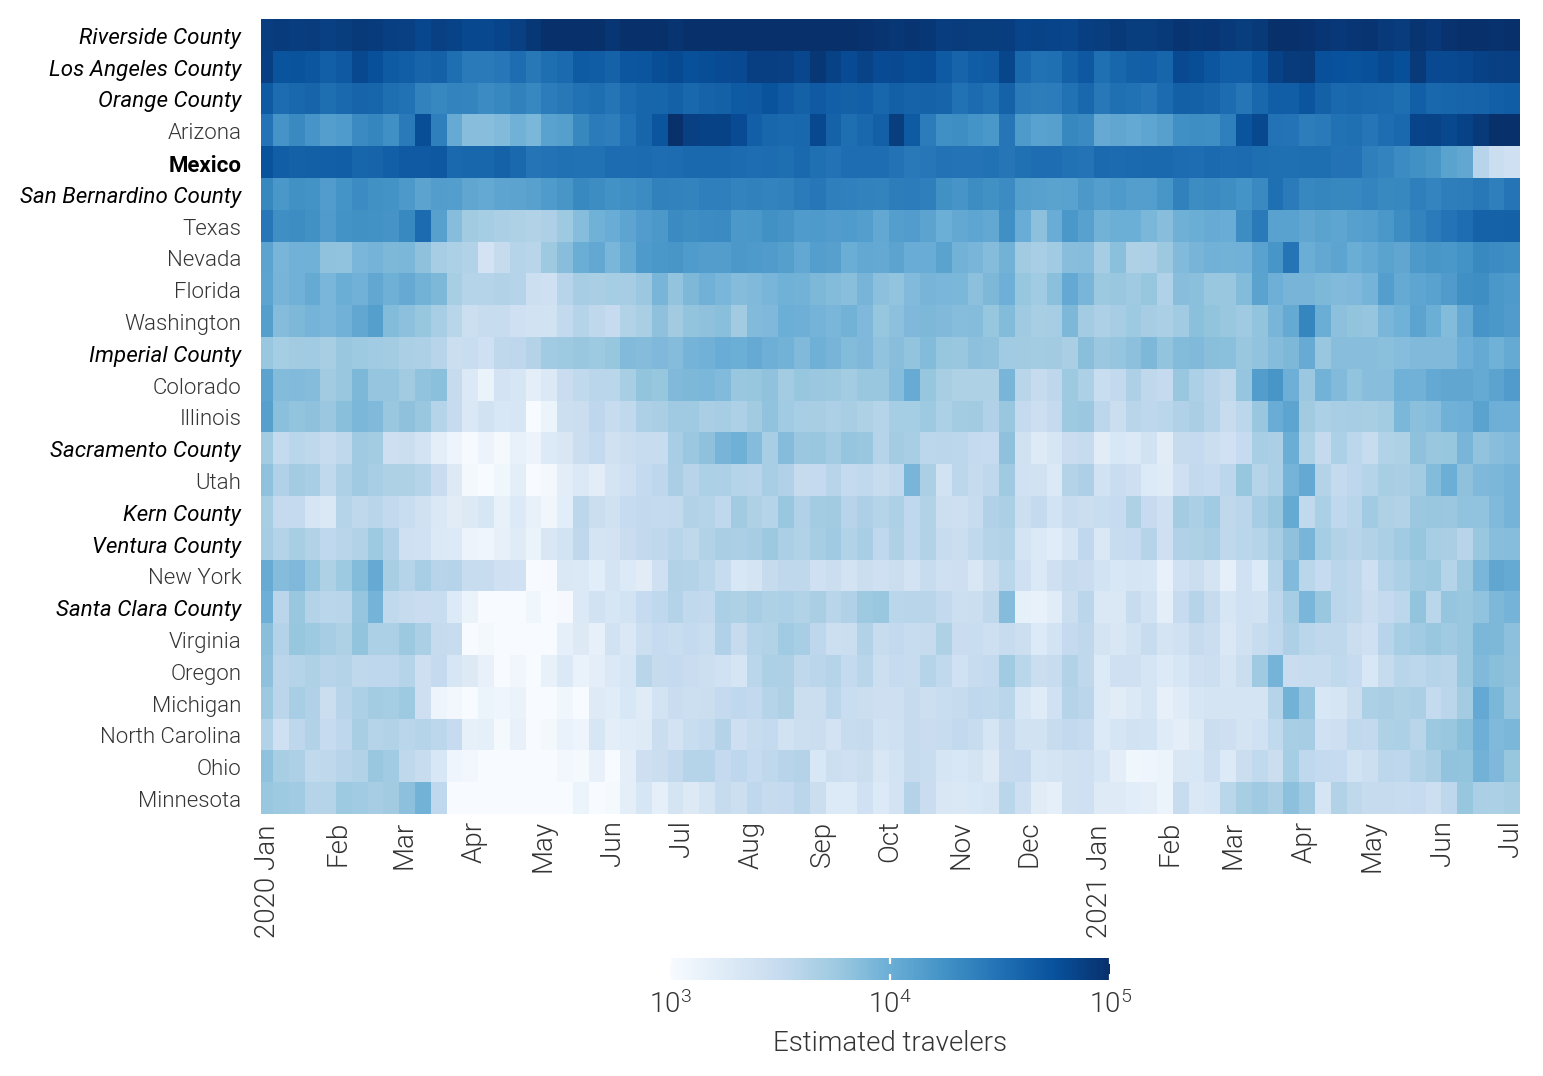

In [3]:
def plot_mobility( df, ax, top=25, log=True, date_range=None, highlights=[], vmin=1000, vmax=1e7, xsize=10, ysize=8, labelsize=10, shrink=0.35, pad=0.13 ):

    plot_df = df.copy()
    plot_df.index = mdates.date2num( plot_df.index )
    plot_df = plot_df.iloc[:,:top]

    if log:
        f1 = ax.imshow( plot_df.T, aspect="auto",
                        norm=LogNorm(vmin=vmin, vmax=vmax ),
                        cmap="Blues", interpolation="nearest",
                        extent=[plot_df.index.min(), plot_df.index.max(), 0, plot_df.shape[1]] )
    else:
        f1 = ax.imshow( plot_df.T, aspect="auto",
                    cmap="Blues", interpolation="nearest",
                    extent=[plot_df.index.min(), plot_df.index.max(), 0, plot_df.shape[1]] )

    ax.set_yticks( np.arange( 0.5, plot_df.shape[1] + 0.5) )
    ax.set_yticklabels( plot_df.columns[::-1] )
    #ax.set_yticks( np.arange(0, plot_df.shape[1]), minor=True)
    #ax.grid( which="minor", axis="y", color="w", linestyle='-', linewidth=1, zorder=5 )

    if date_range is None:
        ax.set_xlim( pd.to_datetime( "2019-12-29" ), pd.to_datetime( "2021-07-05" ) )
    else:
        ax.set_xlim( *date_range )

    ax.xaxis.set_minor_locator( mdates.MonthLocator() )
    ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b' ) )
    ax.xaxis.set_major_locator( mdates.YearLocator() )
    ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

    ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=90, labelsize=xsize, pad=0.01 )
    ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=ysize )

    [ax.spines[j].set_visible(False) for j in ax.spines]

    cbar = plt.colorbar( f1, ax=ax, orientation="horizontal", shrink=shrink, pad=pad, ticks=[1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])#, format=lambda x,y: f"{x:.0%}" )
    cbar.outline.set_visible( False )
    #cbar.ax.set_ylabel( "Estimated number\n of travelers", fontsize=10, labelpad=100, rotation=0, ha="left", va="center" )
    cbar.set_label( "Estimated travelers", fontsize=labelsize )
    cbar.ax.tick_params( labelsize=labelsize, size=2, top=True, bottom=True, color="w", direction="in" )
    cbar.ax.minorticks_off()

    if len( highlights ) > 0:
        for i in ax.get_yticklabels():
            if i.get_text() in highlights:
                i.set_fontweight( "bold" )
                i.set_color( "black" )
            if i.get_text().endswith( "County" ):
                i.set_fontstyle( "italic" )
                i.set_fontweight( "normal" )
                i.set_color( "black" )

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_mobility( mob_mat, ax, highlights=cr["location"].unique(), vmax=1e5 )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_mobility-into-san-diego-matrix.pdf" )
plt.show()

We compare variation in mobility over the timeperiod to the total number of travels.

/var/folders/ct/hf5sjtrx29q3hzh3tqrd53740000gn/T/ipykernel_95107/3981105120.py:1: RuntimeWarning: invalid value encountered in double_scalars
  cov = mob_mat.loc[mob_mat.index > "2019-12-29"].apply( lambda x: x.std() / x.mean() )


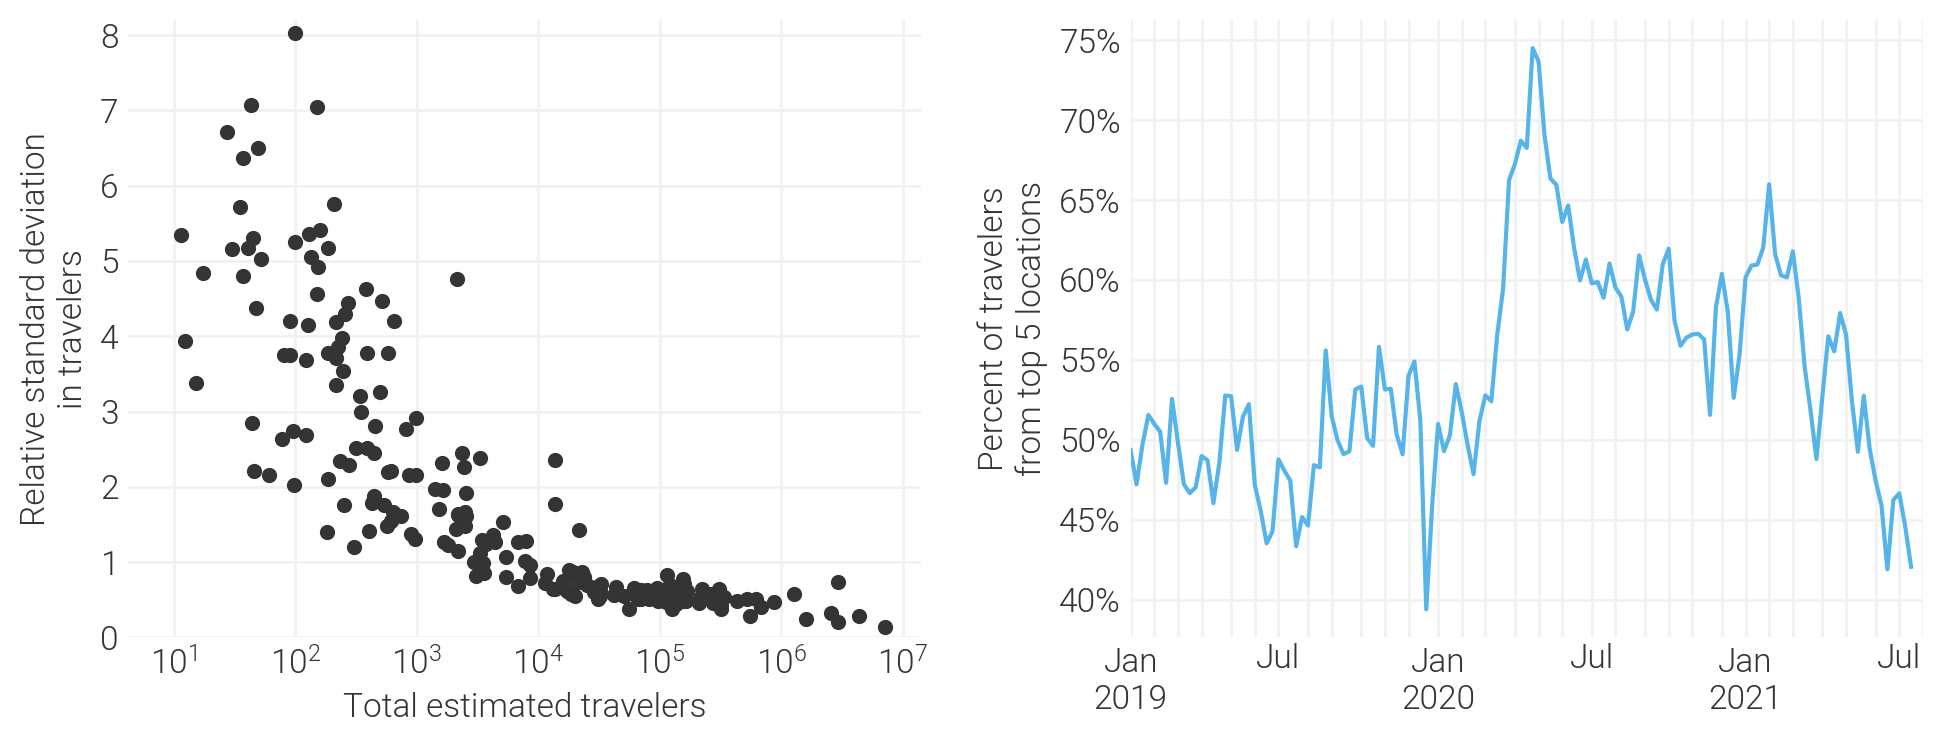

In [9]:
cov = mob_mat.loc[mob_mat.index > "2019-12-29"].apply( lambda x: x.std() / x.mean() )
plot_df = pd.concat( [cov, mob_mat.loc[mob_mat.index > "2019-12-30"].sum()], ignore_index=False, axis=1 )
plot_df.columns = ["cov", "total_travelers"]
#plot_df["total_travelers"] = np.log10( plot_df["total_travelers"] )

top_per = mob_mat.T
top_per = top_per.cumsum() / top_per.sum()

fig, ax = plt.subplots( dpi=200, figsize=(10,4), ncols=2 )
plot_df.plot( x="total_travelers", y="cov", kind="scatter", color=COLOR, ax=ax[0], zorder=10 )
basic_formatting( ax[0], which="both", xlabel="Total estimated travelers", ylabel="Relative standard deviation\nin travelers", spines=[] )
ax[0].set_xscale( "log" )
ax[0].set_xticks( [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7] )
ax[0].tick_params( axis="x", labelrotation=0 )
ax[0].set_ylim( 0, 8.2 )
ax[0].minorticks_off()

top_per.T["Mexico"].plot( ax=ax[1], color="#56B4E9" )
basic_formatting( ax[1], spines=[], which="both", ylabel="Percent of travelers\nfrom top 5 locations", xlims=( pd.to_datetime( "2019-01-01" ), pd.to_datetime( "2021-08-01" ) ) )
ax[1].yaxis.set_major_formatter( PercentFormatter( xmax=1, decimals=0 ) )
ax[1].tick_params( axis="x", which="major", rotation=0 )
ax[1].tick_params( axis="x", which="minor", rotation=0 )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure4_travel-into-san-diego-variance.pdf" )
plt.show()

We noticed that the top 5 locations appeared to be less variable than all other locations. Particular during the general decrease in mobility during March.

In [19]:
february = mob_mat.loc[["2020-02-03", "2020-02-10", "2020-02-17", "2020-02-24"]]
march = mob_mat.loc[["2020-03-02" ,"2020-03-09" ,"2020-03-16" ,"2020-03-23"]]

print( f"Top 5 locations: {1 - (march.iloc[:,:5].sum().sum() / february.iloc[:,:5].sum().sum()):.1%}" )
print( f"All other locations: {1 - (march.iloc[:,5:].sum().sum() / february.iloc[:,5:].sum().sum()):.1%}" )

Top 5 locations: 8.9%
All other locations: 25.0%


We determine the weeks of our sampling period that had the highest increase in estimated travelers relative to the previous weeks.

We note here the following dates:
 - Thanksgiving: Nov 25th
 - Valentine's Day: Feb 14th
 - Memorial day: May 25th (2020) May 31st (2021)
 - Christmas: December 25th
 - Columbus / Indigenous Peoples' day: October 12th (2020)

In [101]:
temp = mob_mat.loc[mob_mat.index > "2019-12-29"].sum( axis=1 )
temp.name = "travelers"
temp = temp.reset_index()
temp["travelers_shift"] = temp["travelers"].shift(1)
temp["travelers_increase"] = temp["travelers"] - temp["travelers_shift"]
temp["increase_pct"] = temp["travelers_increase"] / temp["travelers_shift"] * 100
temp.sort_values( "increase_pct", ascending=False ).head(25)

,date_range_start,travelers,travelers_shift,travelers_increase,increase_pct
47,2020-11-23,468240.960685,362913.696931,105327.263754,29.022675
58,2021-02-08,401853.456376,313005.337028,88848.119347,28.385497
73,2021-05-24,576949.482947,462701.913638,114247.569309,24.691398
63,2021-03-15,497823.836126,406128.904331,91694.931795,22.577790
51,2020-12-21,368582.950993,301728.323043,66854.627950,22.157226
18,2020-05-04,279863.318283,234164.806604,45698.511679,19.515534
6,2020-02-10,496996.888611,429669.231461,67327.657150,15.669648
23,2020-06-08,392864.467761,343531.965911,49332.501850,14.360382
77,2021-06-21,712760.773918,623973.779418,88786.994500,14.229283
20,2020-05-18,350534.121836,307432.959147,43101.162689,14.019695


In [5]:
cumulative_percentage = mob_mat.loc[mob_mat.index > "2019-12-31"].sum()
cumulative_percentage = cumulative_percentage.cumsum() / cumulative_percentage.sum() * 100
cumulative_percentage.head(50)

location
Riverside County         19.955583
Los Angeles County       32.245393
Orange County            40.498538
Arizona                  48.689499
Mexico                   55.877043
San Bernardino County    60.393581
Texas                    63.997383
Nevada                   66.425162
Florida                  68.347408
Washington               70.071929
Imperial County          71.638130
Colorado                 73.116118
Illinois                 74.335626
Sacramento County        75.292530
Utah                     76.229329
Kern County              77.130989
Ventura County           78.018976
New York                 78.884324
Santa Clara County       79.739702
Virginia                 80.548931
Oregon                   81.312530
Michigan                 82.049344
North Carolina           82.787447
Ohio                     83.481995
Minnesota                84.166185
Georgia                  84.848309
Contra Costa County      85.520077
Pennsylvania             86.150148
Alameda Cou

We also looked at reductions in mobility that occured during the three stay-at-home orders enacted in California

In [51]:
ca_mat.max().max()

121460.51

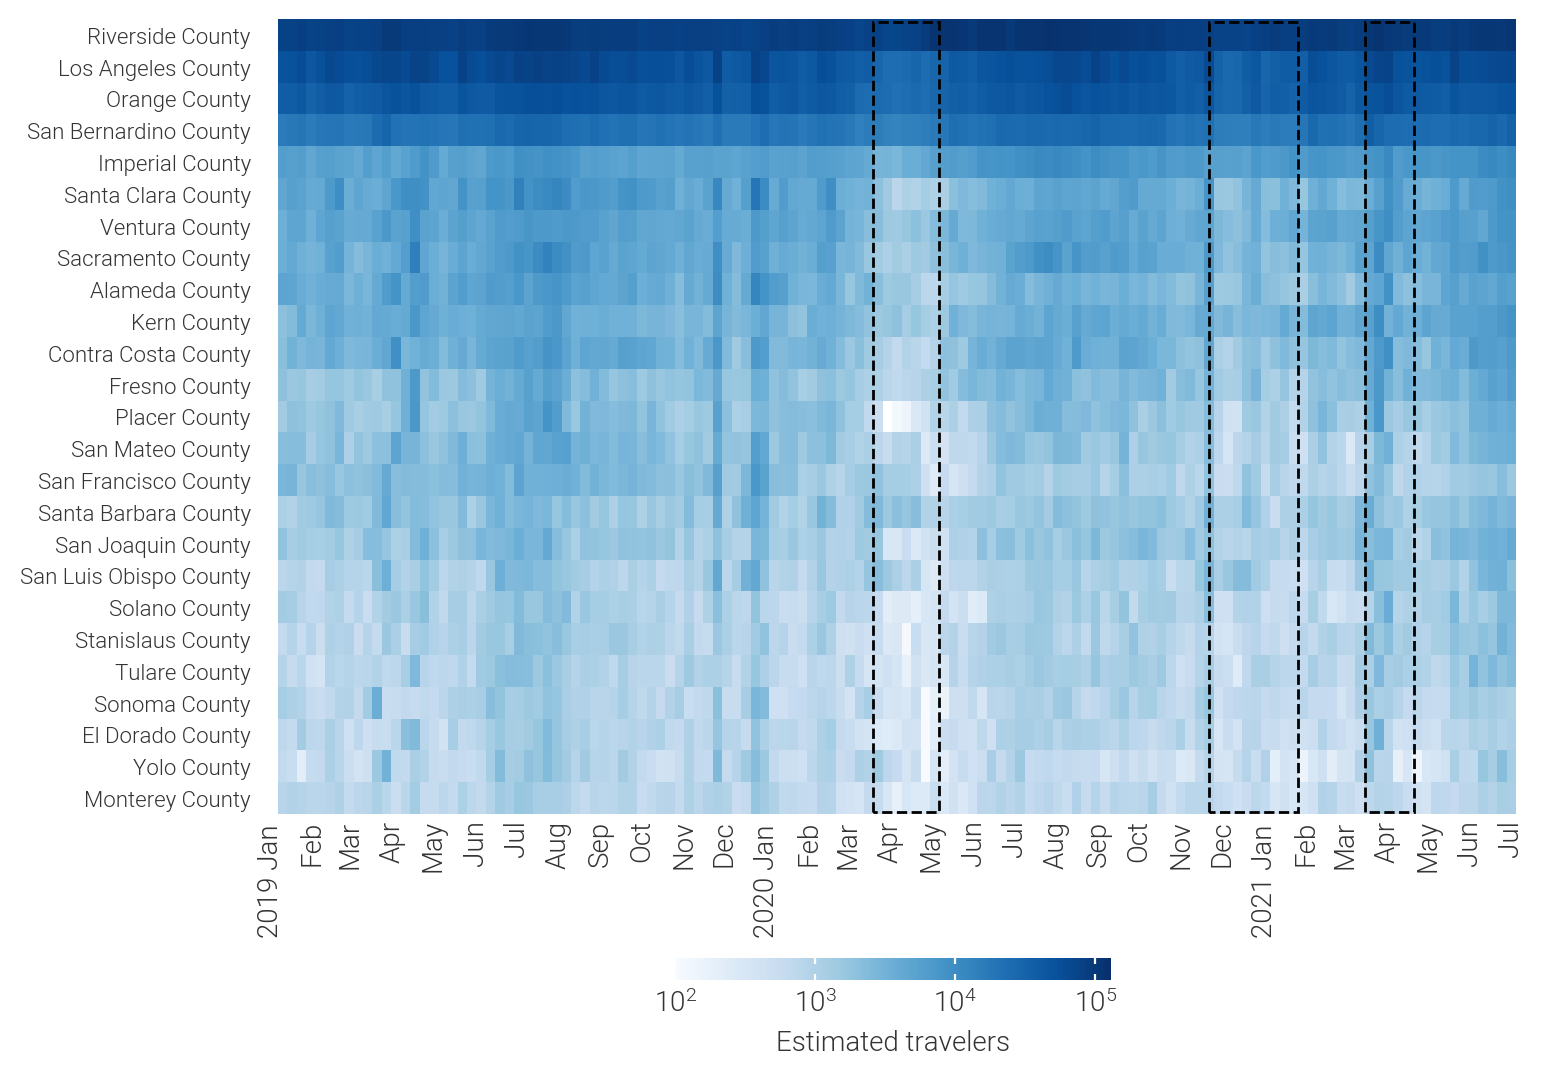

In [54]:
ca_mat = pd.read_csv( "../data/mobility_ca-counties.csv", parse_dates=["date_range_start"], index_col=0 )
fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_mobility( ca_mat, ax, highlights=[], vmax=1.3e5, vmin=1e2 )
ax.set_xlim( pd.to_datetime( "2019-01-01" ) )
ax.axvspan( pd.to_datetime( "2020-03-19" ), pd.to_datetime( "2020-05-07" ), ymax=0.997, ymin=0.003,
           facecolor=(0, 0, 0, 0), edgecolor="black",
           linewidth=1, linestyle="--" )
ax.axvspan( pd.to_datetime( "2020-11-21" ), pd.to_datetime( "2021-01-26" ), ymax=0.997, ymin=0.003,
           facecolor=(0, 0, 0, 0), edgecolor="black",
           linewidth=1, linestyle="--" )
ax.axvspan( pd.to_datetime( "2021-03-16" ), pd.to_datetime( "2021-04-21" ), ymax=0.997, ymin=0.003,
           facecolor=(0, 0, 0, 0), edgecolor="black",
           linewidth=1, linestyle="--" )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure4_travel-into-san-diego-california.pdf" )
plt.show()

# Diagnostic plots
We confirm the presence of an artifact in the international mobility data, beginning on the week encompassing January 1st, 2020.

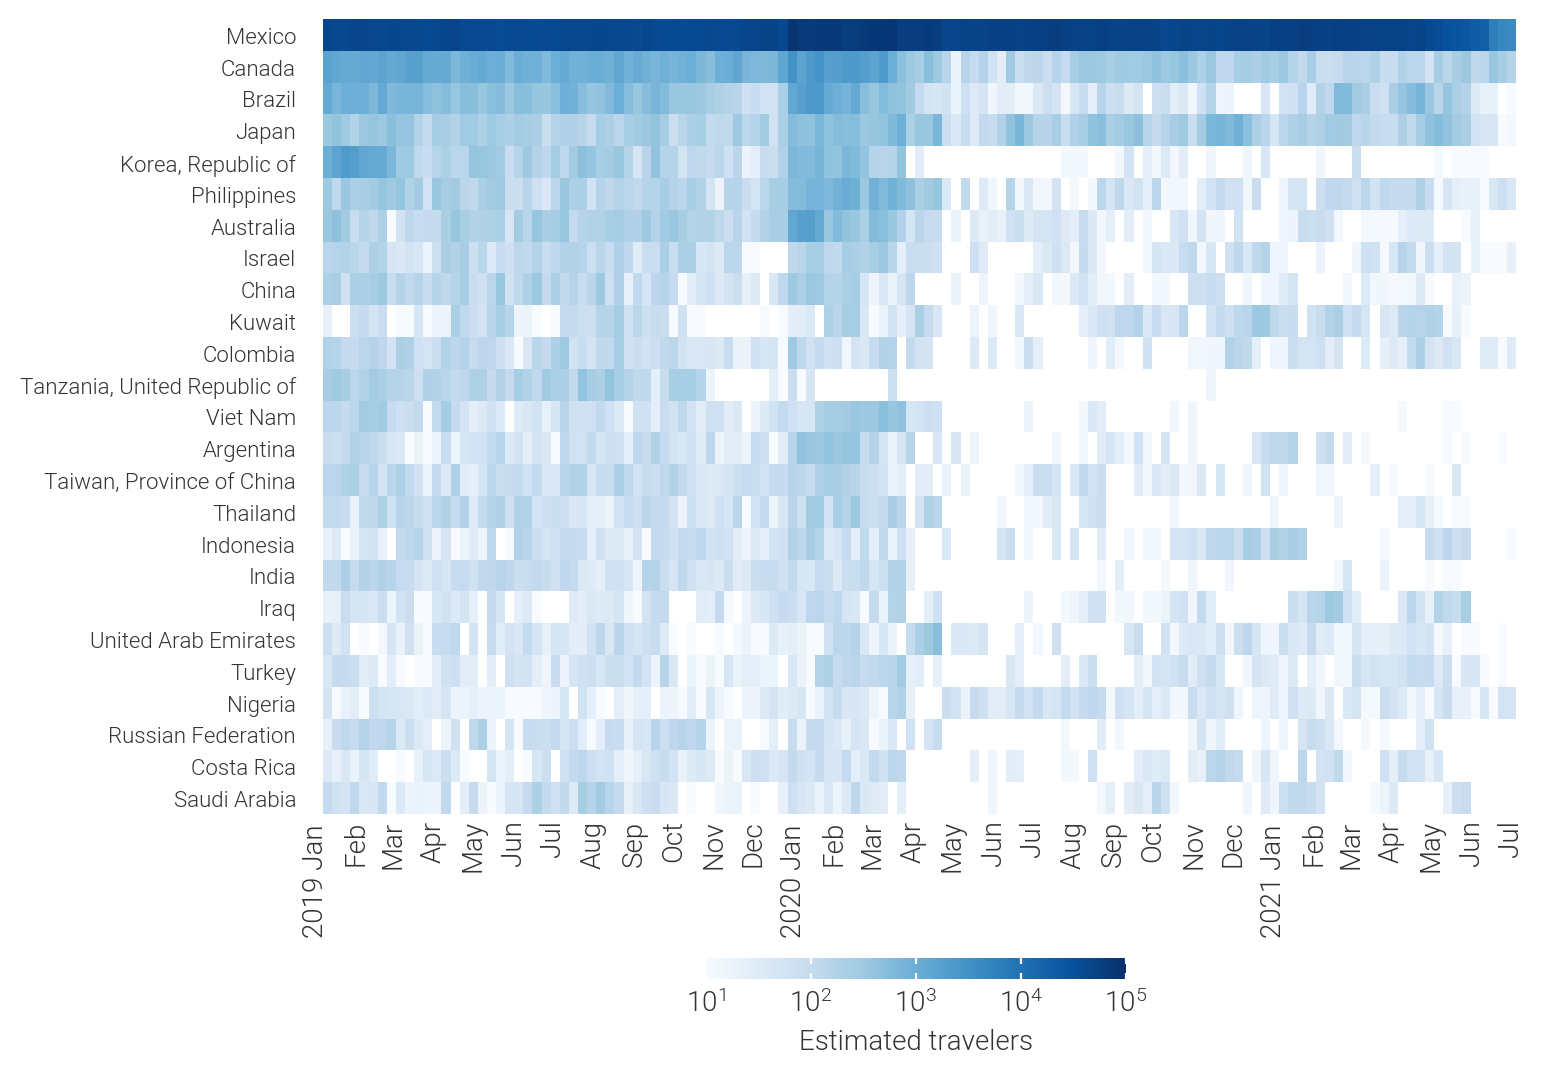

In [27]:
plot_df = cr.pivot( index="date_range_start", columns="location", values="true_visitor_count" )
plot_df = plot_df.reindex( columns=plot_df.sum().sort_values( ascending=False ).index )

fig, ax = plt.subplots( dpi=200, figsize=(8,6) )
plot_mobility( plot_df, ax, highlights=[], vmax=1e5, vmin=1e1 )
ax.set_xlim( pd.to_datetime( "2019-01-01" ) )
plt.tight_layout()
plt.show()

We assess how correcting the artifact effects the ranking of locations' mobility to San Diego. For the 25 locations with the most mobility into San Diego, we plot the log difference between the corrected and uncorrected visitor counts (positive values indicate decrease in travellers estimates due to correction).

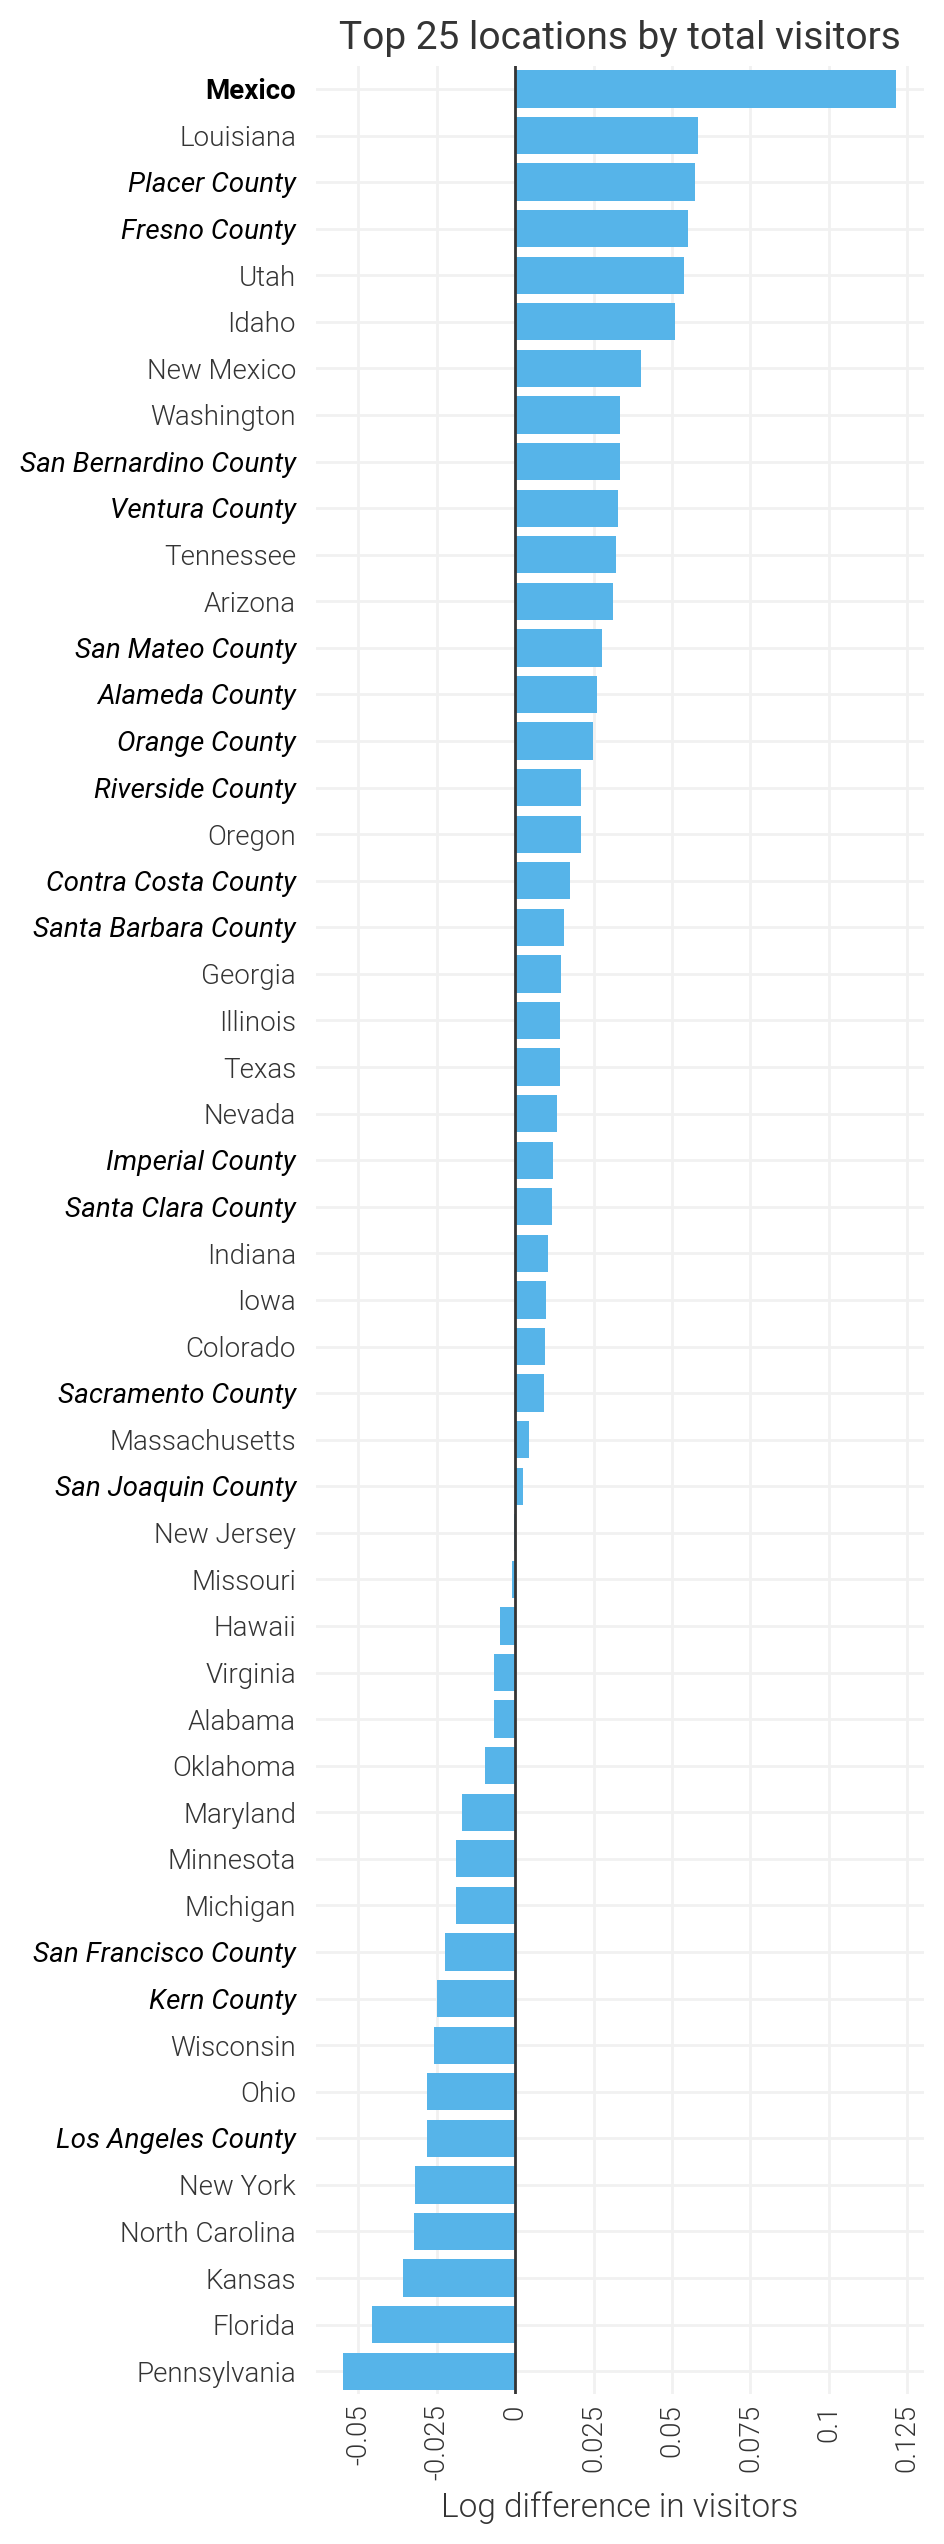

In [30]:
def total_diff( entry ):
    return entry["true_visitor_count"].sum() - entry["corrected_visitor_count"].sum()

def log_diff( entry ):
    return np.log10( entry["true_visitor_count"].sum() ) - np.log10( entry["corrected_visitor_count"].sum() )

temp = pd.merge( diagnostic_df.groupby( "location" ).apply( total_diff ).reset_index( name='total_diff' ), diagnostic_df.groupby( "location" ).apply( log_diff ).reset_index( name='log_diff' ) )
plot_df = temp.loc[temp["location"].isin( (diagnostic_df.loc[~diagnostic_df["location"].isin( ["United States", "California"] )].groupby("location")["true_visitor_count"].sum()).sort_values( ascending=False ).head(50).index  )].sort_values( "log_diff" )
fig, ax = plt.subplots( dpi=200, figsize=(5,13))
ax.barh( y="location", width="log_diff", data=plot_df, zorder=10, color="#56B4E9" )
ax.set_xlabel( "Log difference in visitors", fontsize=12 )
ax.set_ylim( -0.5, 49.5 )
ax.set_xticks( [-0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125] )
ax.set_xticklabels( [-0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1, 0.125] )

ax.set_yticks( np.arange( 0, plot_df.shape[0]) )
ax.set_yticklabels( plot_df["location"] )

for i in ax.get_yticklabels():
    if i.get_text() in ["Mexico"]:
        i.set_fontweight( "bold" )
        i.set_color( "black" )
    if i.get_text().endswith( "County" ):
        i.set_fontstyle( "italic" )
        i.set_fontweight( "normal" )
        i.set_color( "black" )

ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=90, labelsize=10, pad=0.01 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10 )

[ax.spines[j].set_visible(False) for j in ax.spines]
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1  )
ax.axvline( 0, color=COLOR, zorder=11, linewidth=1 )
ax.set_title( "Top 25 locations by total visitors", fontsize=14 )

plt.tight_layout()
#plt.savefig( "../figures/mobility_correction_diff.pdf" )
plt.show()

We next assessed the impact correcting the artifact had on the ranking of locations. In this plot, higher rank indicates greater travel into San Diego.

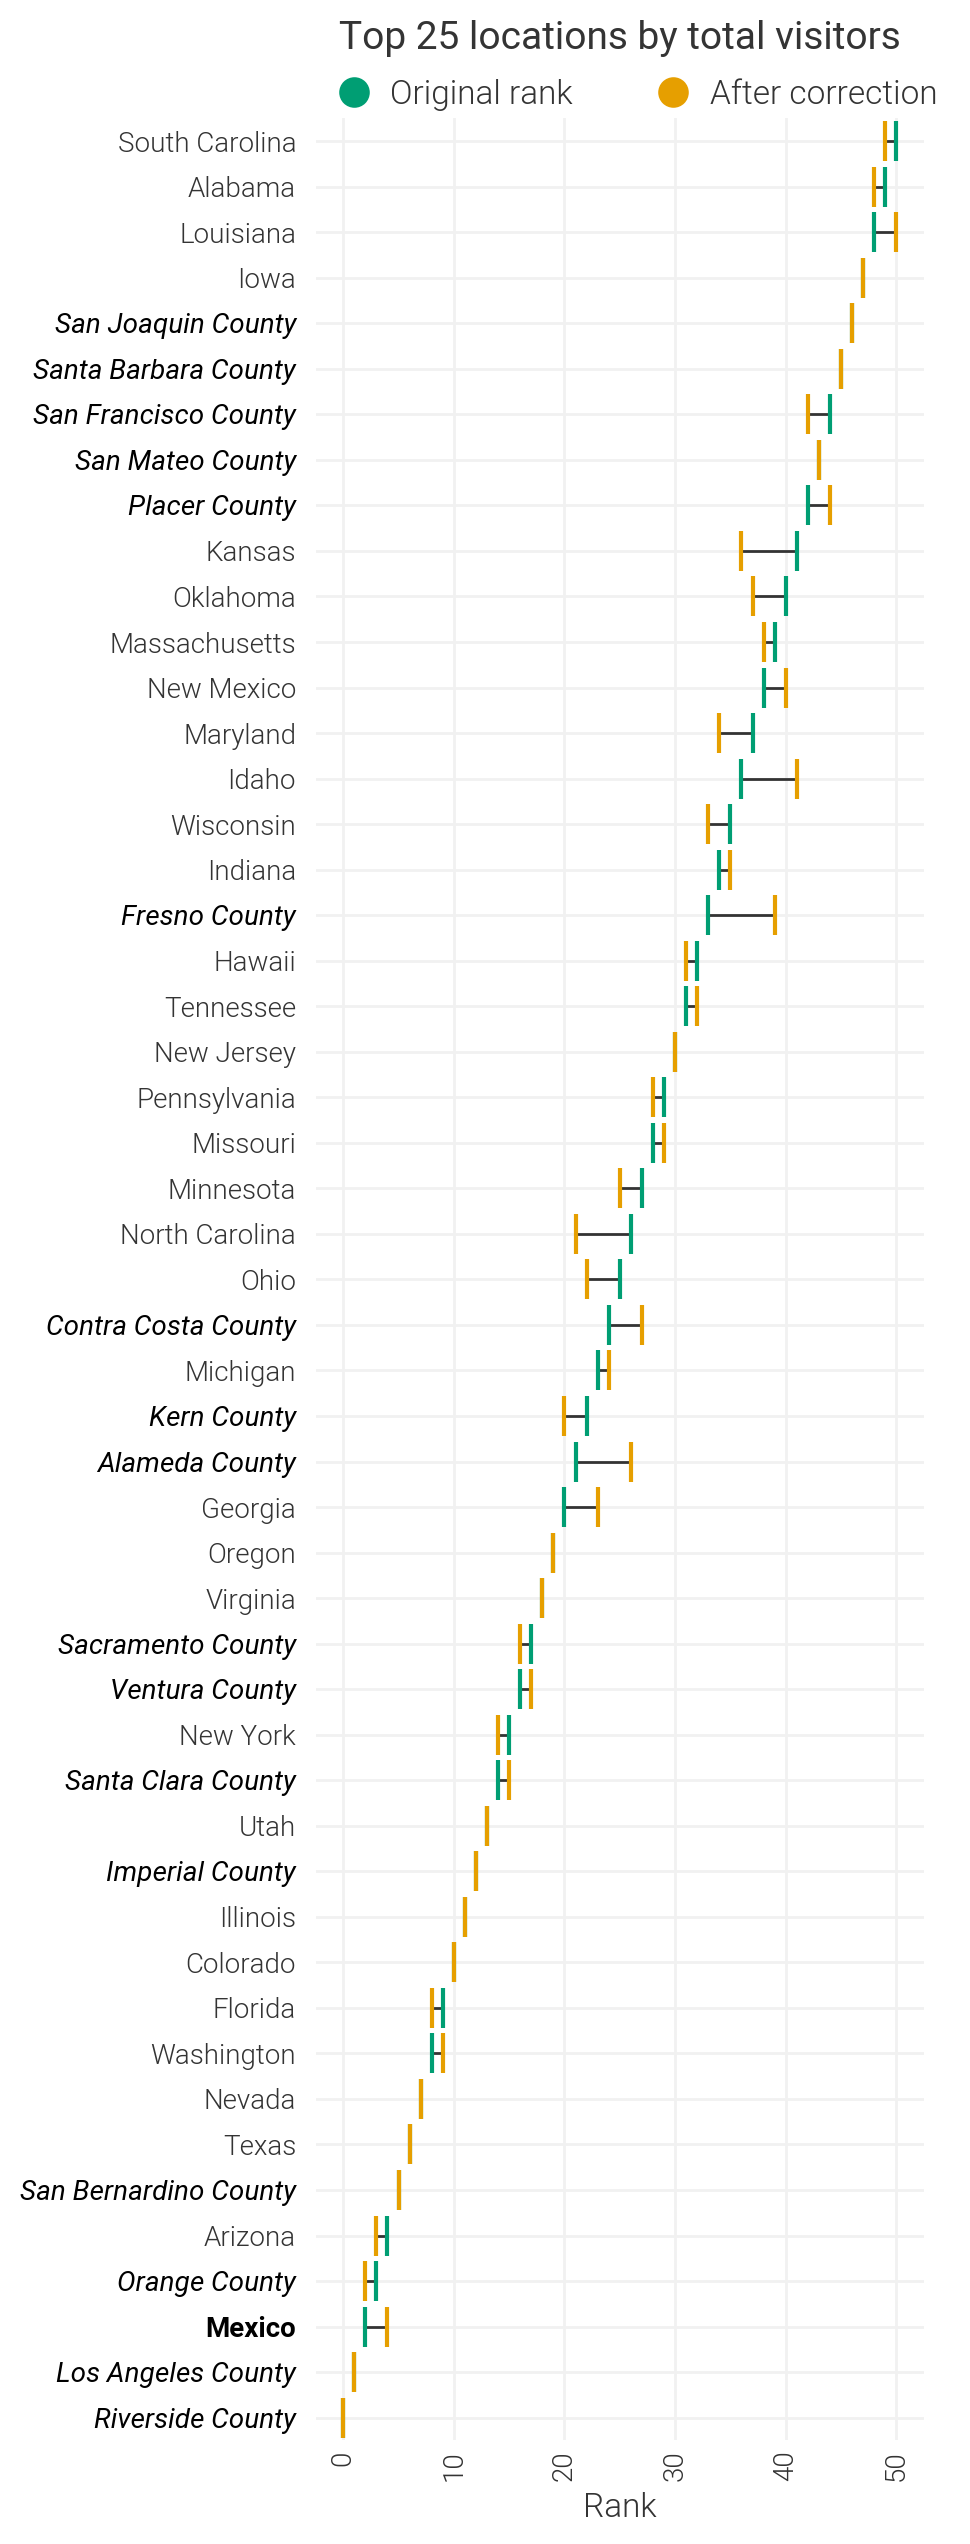

In [31]:
original_order = diagnostic_df.loc[~diagnostic_df["location"].isin( ["United States", "California"] )].groupby( "location" )["true_visitor_count"].sum().sort_values( ascending=False )
original_order = original_order.reset_index().reset_index().set_index( "location" )
original_order = original_order.rename( columns={"index" : "original_order" } )
new_order = diagnostic_df.loc[~diagnostic_df["location"].isin( ["United States", "California"] )].groupby( "location" )["corrected_visitor_count"].sum().sort_values( ascending=False )
new_order = new_order.reset_index().reset_index().set_index( "location" )
new_order = new_order.rename( columns={"index" : "corrected_order" } )

plot_df = pd.merge( original_order, new_order, left_index=True, right_index=True  ).reset_index()
plot_df = plot_df.loc[plot_df["original_order"] < 51]
fig, ax = plt.subplots( dpi=200, figsize=(5,13))
ax.scatter( y="location", x="original_order", data=plot_df, zorder=10, s=200, marker="|", color="#009E73" )
ax.scatter( y="location", x="corrected_order", data=plot_df, zorder=11, s=200, marker="|", color="#E69F00" )
ax.hlines( y="location", xmin="original_order", xmax="corrected_order", data=plot_df, linewidth=1, color=COLOR )

ax.set_xlabel( "Rank", fontsize=12 )
ax.set_yticks( np.arange( 0, plot_df.shape[0]) )
ax.set_yticklabels( plot_df["location"] )
ax.set_ylim( -0.5, 50.5 )

for i in ax.get_yticklabels():
    if i.get_text() in ["Mexico"]:
        i.set_fontweight( "bold" )
        i.set_color( "black" )
    if i.get_text().endswith( "County" ):
        i.set_fontstyle( "italic" )
        i.set_fontweight( "normal" )
        i.set_color( "black" )

ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, rotation=90, labelsize=10, pad=0.01 )
ax.tick_params( axis="y", left=False, which="both", labelleft=True, labelsize=10 )

[ax.spines[j].set_visible(False) for j in ax.spines]
ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1  )
ax.set_title( "Top 25 locations by total visitors", fontsize=14, pad=25 )

legend = [Line2D([0], [0], linestyle='none', marker='o', color="#009E73", label="Original rank", markersize=10 ),
          Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="After correction", markersize=10 )]
ax.legend( loc="upper center", handletextpad=0.1, handles=legend, frameon=False, fontsize=12, bbox_to_anchor=(0,0,1.03,1.03), ncol=2 )


plt.tight_layout()
#plt.savefig( "../figures/mobility_correction_rank.pdf" )
plt.show()